In [ ]:
import requests
from bs4 import BeautifulSoup
import time
from datetime import datetime
import pandas as pd
import warnings
from urllib3.exceptions import InsecureRequestWarning
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import unicodedata

#Limpieza
import nltk
import re
from nltk.corpus import stopwords

#Gráficos
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import math


In [ ]:
# Suprimir la advertencia de seguridad SSL
warnings.simplefilter('ignore', InsecureRequestWarning)

## Obtención de Datos

In [ ]:
base_url = 'https://www.pagina12.com.ar'
seccion_url = 'https://www.pagina12.com.ar/secciones/economia'

Comenzamos creando un función para extraer enlaces de artículos desde un sitio web que tiene paginación. Acepta el parámetro *n_paginas*, que indica cuántas páginas del sitio web se van a procesar. Por defecto, procesa 10.

La función recorre cada página desde la 1 hasta *n_paginas*.

*   url construye la **URL** de la página actual añadiendo el número de página al final (asumiendo una estructura tipo ...?page=1, ...?page=2, etc.).
*   Se utiliza requests para hacer una petición **HTTP** a la **URL**,
*   Se usa **BeautifulSoup** para convertir el **HTML** en un objeto que se puede analizar fácilmente.
*   Se busca todos los **divs** con la clase **article-item__content** que contienen cada artículo, y se almacenan en **articulos**.

Luego, se emplea un bucle for para buscar la etiqueta "a" por cada artículo. Si existe y tiene un atributo href, lo concatena con base_url para formar el enlace completo, y lo agrega a la lista links.

Fiinalmente, se imprime el número de página procesada y la cantidad total de links acumulados.

*   \r sobrescribe la línea anterior (útil para mostrar el progreso en la misma línea).
*   time.sleep(1) agrega una pausa de 1 segundo entre cada página para evitar sobrecargar el servidor (buena práctica).

La función devuelve la lista con todos los enlaces recolectados.

In [ ]:
#Función para obtener links de los articulos de una sección de la web

def obtener_links_articulos(n_paginas=10):
    links = [] #Aquí se almacenarán todos los enlaces extraídos.

    for i in range(1, n_paginas + 1):
        url = f"{seccion_url}?page={i}"
        res = requests.get(url)
        soup = BeautifulSoup(res.content, 'html.parser')
        articulos = soup.find_all('div', class_='article-item__content')

        #Extrae los enlaces
        for articulo in articulos:
            a_tag = articulo.find('a')
            if a_tag and a_tag['href']:
                link = base_url + a_tag['href']
                links.append(link)

        print(f"\rPágina {i} procesada. Total links hasta ahora: {len(links)}", end='', flush=True)
        time.sleep(1)

    print()  # Salto de línea al final
    return links

Creamos una función que tome como parámetro las URL que recopila la función anterior. Luego, de cada URL de un artículo, la función intenta extraer:

*   Título del artículo: Busca la etiqueta "**h1**", que comúnmente contiene el título del artículo. Si existe, extrae el texto limpio; si no, pone 'Sin título'.

*   Fecha de publicación: Busca una etiqueta "**time**" que tenga un atributo datetime. Si la encuentra, extrae ese atributo. Si no lo encuentra, devuelve 'Sin fecha'.

*   **Autor:** Por defecto asume que el autor es 'Anónimo'. Luego, busca un contenedor con clase 'author', y dentro de este, un div con clase 'author-name'. Si lo encuentra, extrae el texto y limpia el prefijo 'Por' si lo tiene.

*   **Texto completo del cuerpo del artículo:** Intenta encontrar el contenido
principal del artículo, buscando primero 'article-text', luego 'article-body'. Luego, dentro de ese div, busca todos los párrafos con etiqueta "**p**". Finalmente, une todos los textos de los párrafos en un solo string. Si no encuentra nada, devuelve 'Sin cuerpo'.

La función termina devolviendo todo eso en un diccionario.

In [ ]:
#Función obtener la información relevante de cada artículo

def extraer_info_articulo(url):
    res = requests.get(url, verify=False)
    soup = BeautifulSoup(res.content, 'html.parser')

    try:
        # Título
        titulo_tag = soup.find('h1')
        titulo = titulo_tag.get_text(strip=True) if titulo_tag else 'Sin título'

        # Fecha
        fecha_tag = soup.find('time', {'datetime': True})
        fecha = fecha_tag.get('datetime') if fecha_tag else 'Sin fecha'

        # Autor
        autor = 'Anónimo'
        autor_container = soup.find('div', class_='author')
        if autor_container:
            autor_tag = autor_container.find('div', class_='author-name')
            if autor_tag:
                autor = autor_tag.get_text(strip=True).replace('Por', '').strip()

        # Cuerpo del artículo
        cuerpo_div = soup.find('div', class_='article-text') or soup.find('div', class_='article-body')
        if cuerpo_div:
            parrafos = cuerpo_div.find_all('p')
            cuerpo = " ".join([p.get_text() for p in parrafos])
        else:
            cuerpo = 'Sin cuerpo'

        return {'titulo': titulo, 'fecha': fecha, 'autor': autor, 'texto': cuerpo, 'url': url}

    except Exception as e:
        print(f"\nError con {url}: {e}")
        return None

Llamamos a la primera función para recolectar enlaces de artículos, y los guardamos en una lista. En este caso, desde 200 páginas.

In [ ]:
links = obtener_links_articulos(n_paginas=200)  # O la cantidad que se quiera

Página 200 procesada. Total links hasta ahora: 2200


Inicializamos una lista llamada datos. Luego, recorremos cada enlace y extraemos la información, utilizando la segunda función extraer_info_articulo(link), y se guarda en la lista.

Se usa **enumerate()** para tener el índice y el link al mismo tiempo.

Si el resultado no es None, lo guarda en la lista datos.

In [ ]:
datos = []

for i, link in enumerate(links):
    articulo = extraer_info_articulo(link)

    if articulo:
        datos.append(articulo)

    print(f"\rProcesados {i + 1}/{len(links)} artículos...", end='', flush=True)
    time.sleep(1)

print()  # Salto de línea al final

Procesados 2200/2200 artículos...


In [ ]:
# Convertimos los artículos en un DataFrame de pandas
df_articulos = pd.DataFrame(datos)
df_articulos.head()

,titulo,fecha,autor,texto,url
0,El golpe contra la industria pyme,2025-04-17T00:01:00-03:00,Raúl Dellatorre,La preocupación en el sector industrial por la...,https://www.pagina12.com.ar/818837-el-golpe-co...
1,Inusual baja del dólar minorista,2025-04-17T00:01:00-03:00,Anónimo,En el tercer día de vigencia de la liberación ...,https://www.pagina12.com.ar/818856-inusual-baj...
2,Avalancha de bienes de consumo,2025-04-17T01:48:42-03:00,Bernarda Tinetti,La balanza comercial registró en marzo un supe...,https://www.pagina12.com.ar/818862-avalancha-d...
3,Vista compra Petronas,2025-04-17T00:01:00-03:00,Anónimo,"La petrolera del ex titular de YPF, Miguel Gal...",https://www.pagina12.com.ar/818864-vista-compr...
4,Superávit con ganadores y perdedores,2025-04-17T00:01:00-03:00,Mara Pedrazzoli,"En marzo, el Sector Público Nacional (SPN) reg...",https://www.pagina12.com.ar/818866-superavit-c...


In [ ]:
articulos_por_autor = df_articulos.groupby('autor').size()
print(articulos_por_autor)

autor
Alfredo Zaiat             21
Anónimo                 1691
Bernarda Tinetti          46
Betina Stein               1
Carlos Heller              2
David Cufré               22
Federico Kucher           15
Hernán Letcher             1
Javier Lewkowicz          19
Juan Pablo Csipka          1
Julio Gambina              4
Leandro Renou            131
Manuela Tobia              1
Mara Pedrazzoli          153
Natalí Risso              22
Pedro Peretti              5
Raúl Dellatorre           60
Vardan Bleyan              4
Álvaro García Linera       1
dtype: int64


In [ ]:
# Convertimos la columna 'fecha' a datetime.
df_articulos['fecha'] = pd.to_datetime(df_articulos['fecha'], errors='coerce')

In [ ]:
# Extraemos año y mes
df_articulos['anio_mes'] = df_articulos['fecha'].dt.to_period('M')

<ipython-input-12-4d16b6ad530b>:2: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df_articulos['anio_mes'] = df_articulos['fecha'].dt.to_period('M')


In [ ]:
# Vemos cuántos artículos tenemos por año y mes
articulos_por_mes = df_articulos.groupby('anio_mes').size()
print(articulos_por_mes)

anio_mes
2024-07    108
2024-08    172
2024-09    148
2024-10    164
2024-11    157
2024-12    180
2025-01    185
2025-02    180
2025-03    174
2025-04    109
Freq: M, dtype: int64


In [ ]:
# Eliminamos duplicados (por texto o URL)
df_articulos = df_articulos.drop_duplicates(subset='texto')
df_articulos = df_articulos.drop_duplicates(subset='url')

In [ ]:
# Ver cuántos artículos quedaron por año y mes sin duplicados
articulos_por_mes = df_articulos.groupby('anio_mes').size()
print(articulos_por_mes)

anio_mes
2024-07    107
2024-08    172
2024-09    148
2024-10    161
2024-11    156
2024-12    176
2025-01    185
2025-02    180
2025-03    171
2025-04    108
Freq: M, dtype: int64


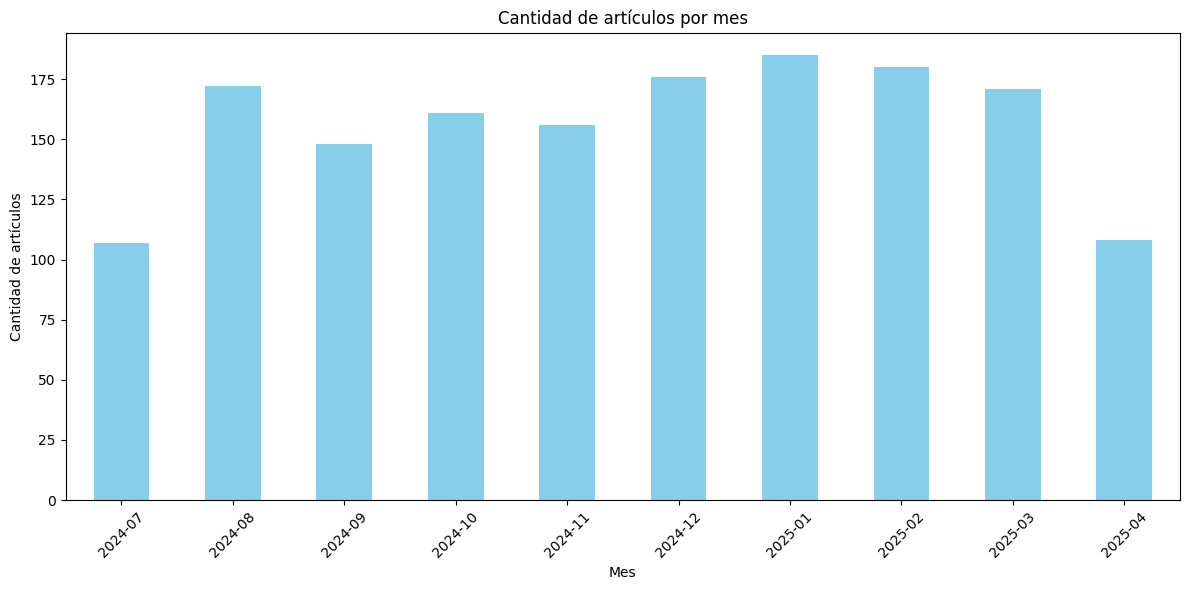

In [ ]:
# Vemos gráficamente cuántos artículos quedaron por año y mes sin duplicados
articulos_por_mes.plot(kind='bar', figsize=(12,6), color='skyblue')
plt.title('Cantidad de artículos por mes')
plt.xlabel('Mes')
plt.ylabel('Cantidad de artículos')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Limpieza de los Datos

In [ ]:
# Descargamos 'stopwords'
nltk.download('stopwords')

stopwords_es = set(stopwords.words('spanish'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Creamos una lista de stopwords en español, y a su vez creamos una lista de stopwords personalizada.

In [ ]:
# Lista de stopwords en español
stopwords_es = stopwords.words('spanish')
# Creamos una lista de stopwords personalizada
stopwords_custom = ['gobierno', 'presidente', 'economía', 'argentina', '2025', '2024', 'año',
                    'enero', 'febrero', 'marzo', 'abril', 'mayo', 'junio', 'julio', 'agosto',
                    'septiembre', 'octubre', 'noviembre', 'diciembre', 'mientras', 'ciento',
                    'lunes','martes', 'miércoles', 'jueves', 'viernes', 'sábado', 'domingo',
                    'dólar','dólares', 'peso','pesos', 'según', 'mientras', 'día', 'pais', 'año',
                    'nacional', 'millones', 'país', 'mes', 'meses', 'sector', 'respecto', 'si',
                    'ministro', 'cada', 'vez', 'tipo', 'tipos', 'vivo', 'cotizaciones', 'mismo',
                    'período', 'compra', 'venta', 'ciudad', 'buenos', 'aires', 'puntos', 'parte',
                    'porcentuales', 'básicos', 'puestos', 'unidos', 'además', 'último', 'últimos',
                    'total', 'solo', 'promedio', 'mil', 'uno', 'dos','días']
stopwords_personalizadas = stopwords_es + stopwords_custom

Creamos una lista de palabras combinadas importantes, como "Banco Central" o "Estados Unidos".

In [ ]:
# Lista de combinaciones de palabras importantes
combinaciones = ['banco central', 'luis caputo', 'fondo monetario internacional', 'boletín oficial',
                 'wall street', 'estados unidos', 'poder adquisitivo', 'acuerdo fmi', 'nuevo acuerdo',
                 'reservas internacionales', 'donald trump', 'javier milei', 'acuerdo fondo', 'índice precios',
                 'mercado interno', 'mara pedrazzoli', 'banco nación', 'energía eléctrica','salario mínimo',
                 'axel kicillof', 'federico sturzenegger']
combinaciones = [c.lower().strip() for c in combinaciones]

Creamos una función para limpiar el texto de los artículos, aplicando:

*   Converción a minúsculas
*   Eliminación de números: Borra cualquier número (como fechas, precios, años).
*   Eliminación de puntuación y caracteres especiales: Borra símbolos como . , ! ? ¡ ¿ ", etc, y mantiene letras, espacios y guiones bajos
*   Eliminación de stopwords personalizadas: Primero dividiendo el texto en palabras, luego elimina cualquier palabra que esté en la lista de stopwords.

Finalmente, se reconstruye el texto limpio, volviendo a unir las palabras ya filtradas en un solo string, separado por espacios.

In [ ]:
# Función de limpieza de texto para los artículos.
def limpiar_texto(texto, stopwords_personalizadas):
    # Convertimos a minúsculas
    texto = texto.lower()

    # Eliminamos números y fechas (si no son relevantes)
    texto = re.sub(r'\d+', '', texto)

    # Eliminamos caracteres especiales, puntuación y saltos de línea/tabulaciones
    texto = re.sub(r'[^\w\s_]', '', texto)  # Cambio para permitir los guiones bajos en las combinaciones

    # Eliminamos las stopwords personalizadas
    palabras = texto.split()
    palabras = [palabra for palabra in palabras if palabra not in stopwords_personalizadas]

    # Unimos las palabras de nuevo en un solo texto
    return ' '.join(palabras)

Creamos una función que busca combinaciones de palabras específicas dentro de un texto y las reemplaza por la misma frase pero con guión bajo entre las palabras.

Esto se hace para que esas combinaciones se traten como una sola palabra, en vez de ser divididas durante el procesamiento del texto.

In [ ]:
def eliminar_tildes(texto):
    return ''.join(
        c for c in unicodedata.normalize('NFD', texto)
        if unicodedata.category(c) != 'Mn'
    )

In [ ]:
# Función para reemplazar las combinaciones antes de la limpieza
def reemplazar_combinaciones(texto, combinaciones):
    texto = texto.lower()
    texto = eliminar_tildes(texto)

    for combinacion in combinaciones:
        combinacion = combinacion.lower().strip()
        combinacion = eliminar_tildes(combinacion)
        texto = texto.replace(combinacion, combinacion.replace(" ", "_"))

    return texto

In [ ]:
# Aplicamos el reemplazo de combinaciones en el texto limpio
df_articulos['texto_limpio'] = df_articulos['texto_limpio'].apply(lambda x: reemplazar_combinaciones(x, combinaciones))

In [ ]:
# Limpiamos el texto ya preparado
df_articulos['texto_limpio'] = df_articulos['texto_limpio'].apply(
    lambda x: limpiar_texto(x, stopwords_personalizadas)
)

El resultado de la limpieza es el siguiente:

In [ ]:
df_articulos[['texto', 'texto_limpio']].head(5)

,texto,texto_limpio
0,La preocupación en el sector industrial por la...,preocupacion industrial consecuencias nueva fa...
1,En el tercer día de vigencia de la liberación ...,tercer vigencia liberacion cepo cambiario part...
2,La balanza comercial registró en marzo un supe...,balanza comercial registro superavit mantuvo v...
3,"La petrolera del ex titular de YPF, Miguel Gal...",petrolera ex titular ypf miguel galuccio adqui...
4,"En marzo, el Sector Público Nacional (SPN) reg...",publico spn registro superavit primario billon...


In [ ]:
print(df_articulos['texto_limpio'])

0       preocupacion industrial consecuencias nueva fa...
1       tercer vigencia liberacion cepo cambiario part...
2       balanza comercial registro superavit mantuvo v...
3       petrolera ex titular ypf miguel galuccio adqui...
4       publico spn registro superavit primario billon...
                              ...                        
2194    afip extendio plazo recategorizacion monotribu...
2195    politica cielos abiertos llamada desregulacion...
2197    recesion haciendo estragos surge informe unive...
2198    segui cerro traves decreto publicado boletin_o...
2199    salio ponerle panos frios rumor dejado trascen...
Name: texto_limpio, Length: 1565, dtype: object


In [ ]:
# Guardamos el DataFrame como pickle
df_articulos.to_pickle('articulos_economia_limpio.pkl')

## Creación de Bag of Words

In [ ]:
# Ahora, creamos el Bag of Words
vectorizer = CountVectorizer(
    stop_words=stopwords_personalizadas,
    token_pattern=r'(?u)\b\w[\w_]+\b'  # permite letras, números y guión bajo
    )

# Creamos la matriz términos-documentos
X = vectorizer.fit_transform(df_articulos['texto_limpio'])

# Convertimos a DataFrame
bow_df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())

In [ ]:
bow_df.head()

,aa,aaa,aaar,aabe,aaeta,aalario,aapresid,aba,abad,abajo,...,zuban,zubizarreta,zuchoviki,zuckerberg,zucman,zug,zuppi,zurdos,zurich,zurita
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
# Sumamos las frecuencias por palabra
frecuencias_totales = bow_df.sum(axis=0).sort_values(ascending=False)

# Mostramos las 10 palabras más frecuentes
print(frecuencias_totales.head(10))

mercado         1115
inflacion       1083
precios         1008
caida            940
aumento          892
milei            787
javier_milei     766
baja             759
empresas         754
interanual       667
dtype: int64


## Aplicación de TF-IDF

In [ ]:
# Creamos el vectorizador TF-IDF
tfidf_vectorizer = TfidfVectorizer(
    stop_words=stopwords_personalizadas,
    token_pattern=r'(?u)\b\w[\w_]+\b'
    )

# Aplicamos TF-IDF al texto
X_tfidf = tfidf_vectorizer.fit_transform(df_articulos['texto_limpio'])

# Convertimos la matriz TF-IDF a un DataFrame
tfidf_df = pd.DataFrame(X_tfidf.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

# Sumamos las frecuencias ponderadas (TF-IDF) por palabra
frecuencias_tfidf = tfidf_df.sum(axis=0).sort_values(ascending=False)

# Mostramos las 10 palabras más importantes según TF-IDF
print(frecuencias_tfidf.head(10))

inflacion       30.003669
mercado         28.974040
precios         27.652317
caida           25.902263
aumento         23.503735
javier_milei    22.885330
interanual      21.840048
consumo         21.224953
baja            20.629674
produccion      20.415173
dtype: float64


In [ ]:
# Añadimos la columna de tiempo al tfidf_df que tenemos en df_articulos
tfidf_df['anio_mes'] = df_articulos['anio_mes'].values

## WordCloud

In [ ]:
def generar_nubes_palabras_por_mes(tfidf_df, anio_mes_col='anio_mes', top_n=30, columnas=3):
    # Agrupamos por año_mes y calculamos el promedio de TF-IDF
    tfidf_por_mes = tfidf_df.groupby(anio_mes_col).mean()

    # Calcular cantidad de filas necesarias
    filas = math.ceil(len(tfidf_por_mes) / columnas)
    fig, axs = plt.subplots(filas, columnas, figsize=(20, 5 * filas))

    # Meses en español
    meses_es = [
        "enero", "febrero", "marzo", "abril", "mayo", "junio",
        "julio", "agosto", "septiembre", "octubre", "noviembre", "diciembre"
    ]

    # Iterar por mes y generar cada nube
    for i, (mes, row) in enumerate(tfidf_por_mes.iterrows()):
        # Top N palabras
        top_palabras = dict(row.nlargest(top_n))

        # Crear WordCloud
        wordcloud = WordCloud(width=800, height=400, background_color='white')\
            .generate_from_frequencies(top_palabras)

        # Título: nombre del mes + año
        titulo = f'{meses_es[mes.month - 1].capitalize()} {mes.year}'

        # Posición del subplot
        fila, col = divmod(i, columnas)
        ax = axs[fila, col] if filas > 1 else axs[col]
        ax.imshow(wordcloud, interpolation='bilinear')
        ax.set_title(titulo, fontsize=14)
        ax.axis('off')

    # Ocultar subplots vacíos
    for j in range(len(tfidf_por_mes), filas * columnas):
        fila, col = divmod(j, columnas)
        ax = axs[fila, col] if filas > 1 else axs[col]
        ax.axis('off')

    plt.tight_layout()
    plt.show()

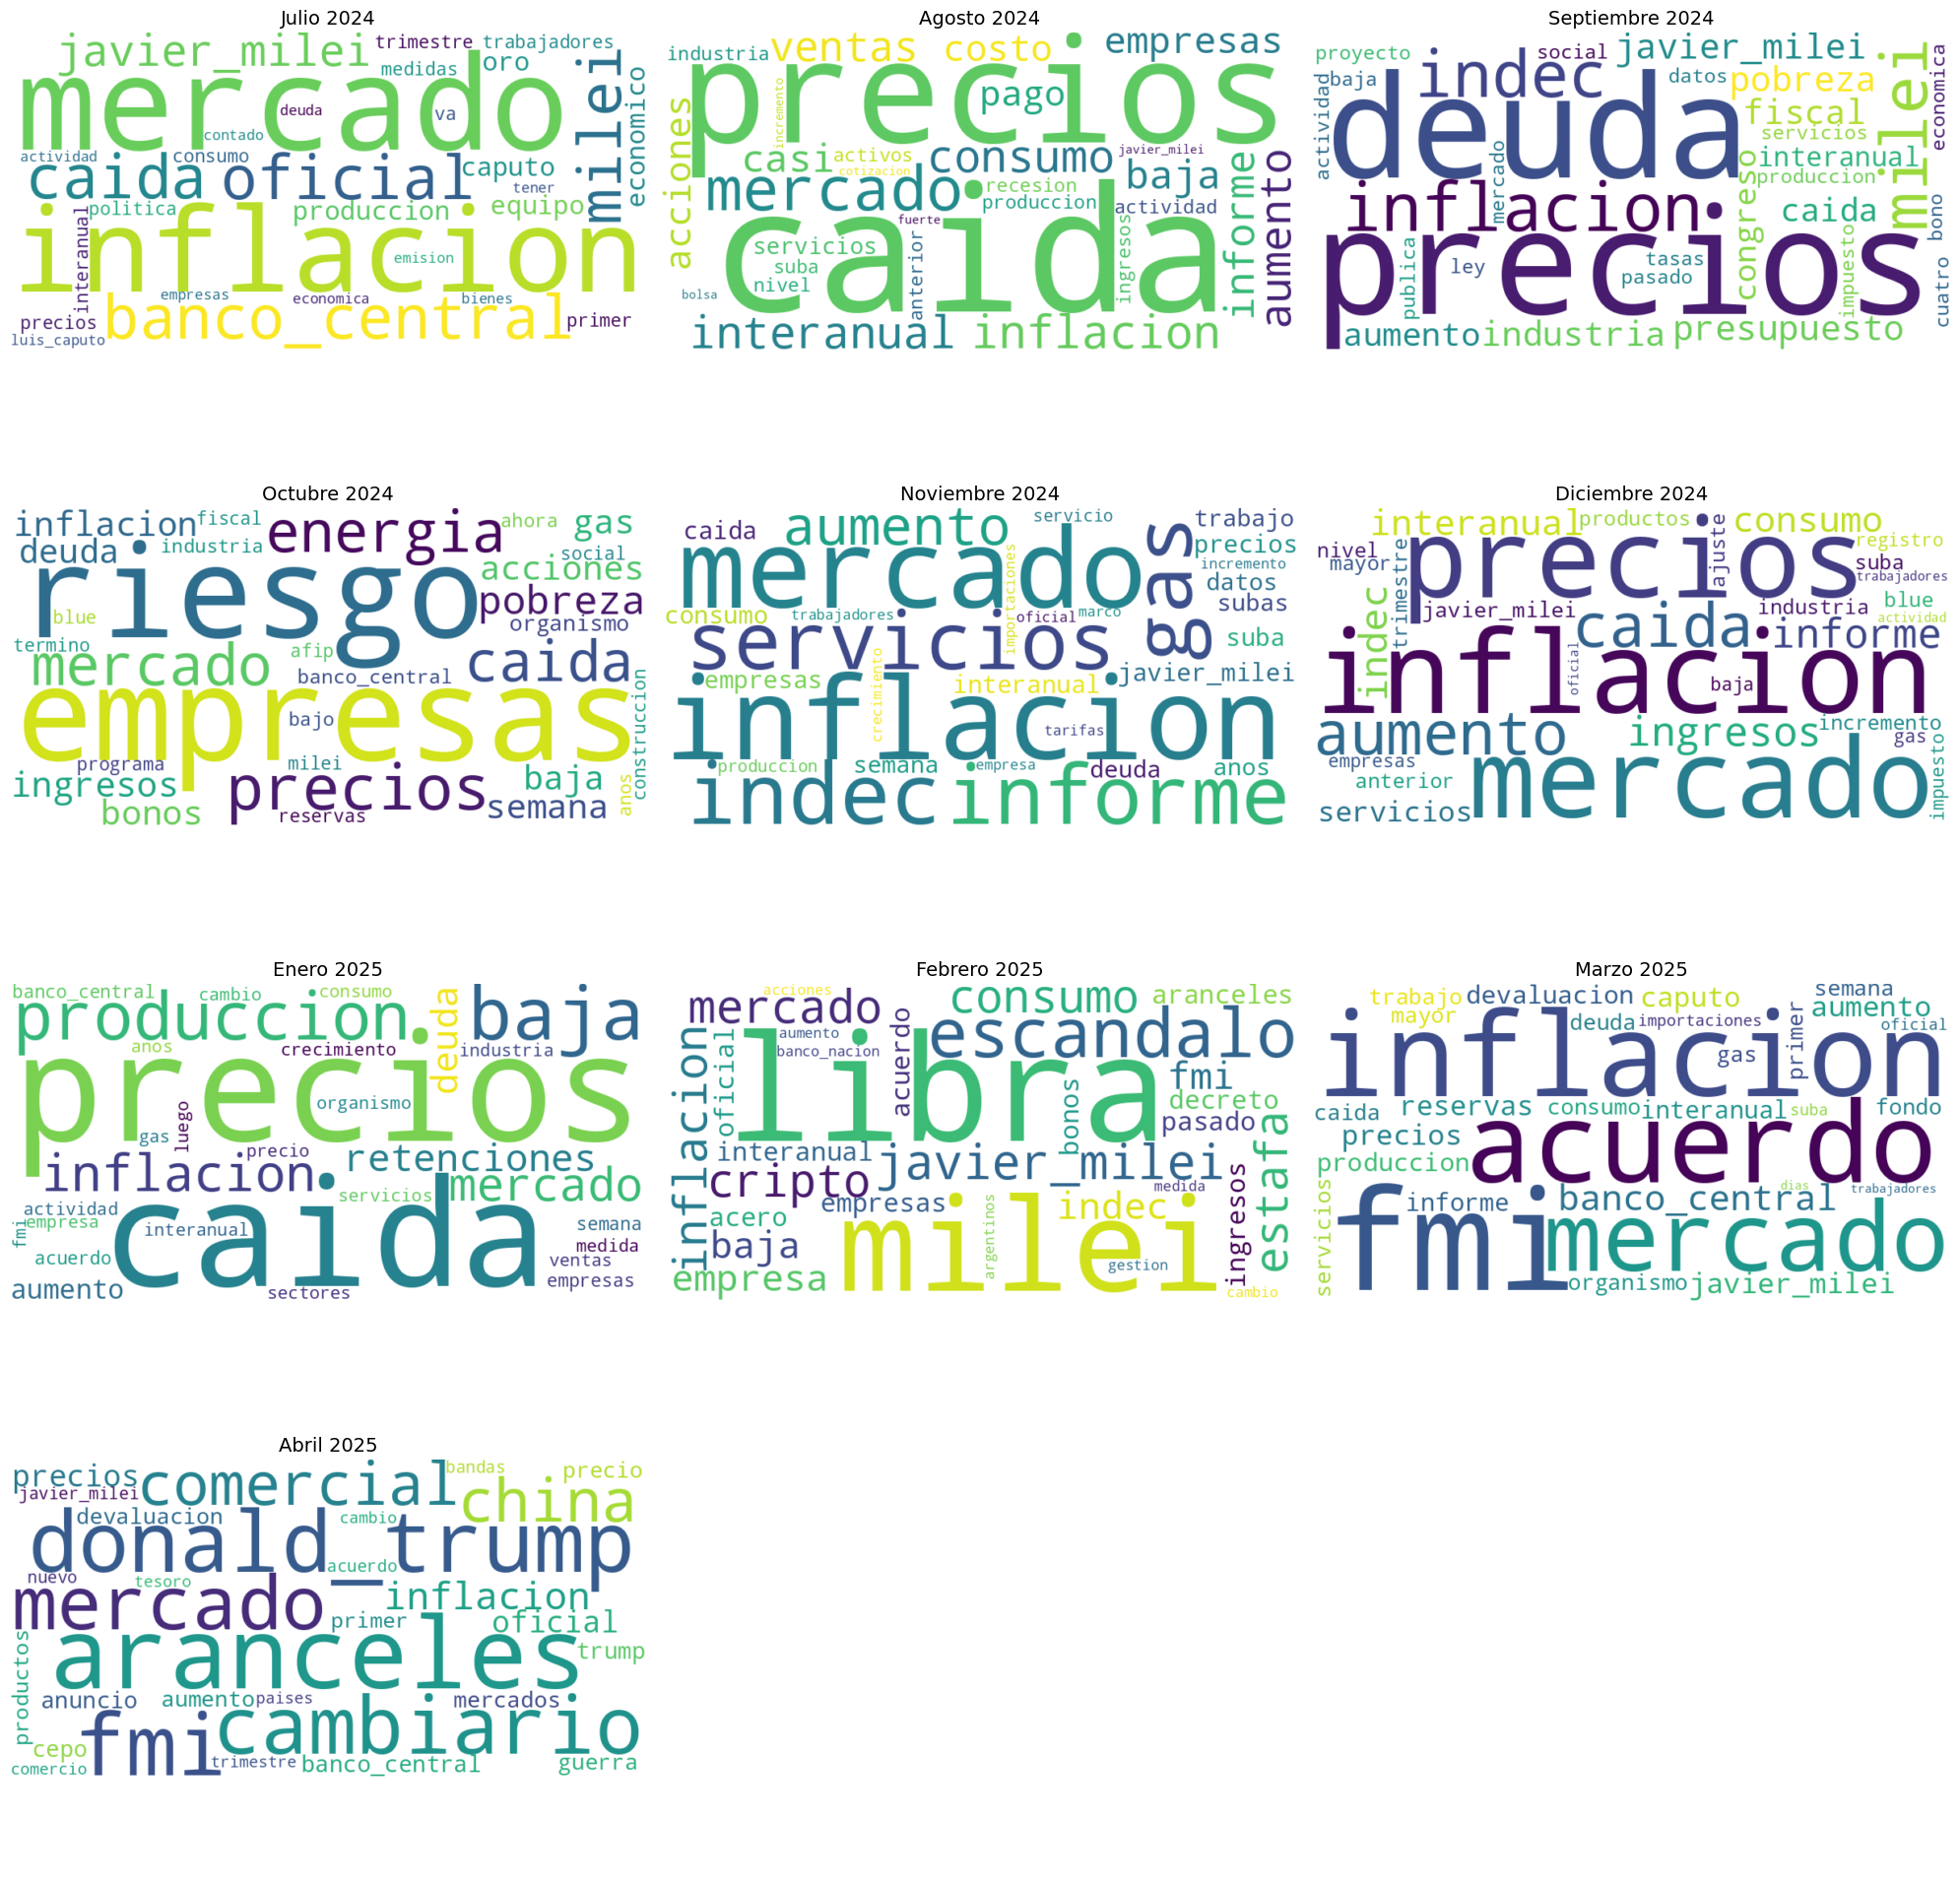

In [ ]:
generar_nubes_palabras_por_mes(tfidf_df)